### Group Members:
#### - Stuti Patel (122013834) <br>- Riya Puri (122099296)<br>- Kshitij Lnu (121507990)

---
# F1 Pit Stop Lap and Count Prediction using Machine Learning
---

We are building a data driven model to understand and predict Formula 1 pit stop strategy using historical race data. Here we combined multiple F1 datasets to create a single race level view for each driver, cleaned common data issues such as pit lane starts and missing qualifying positions, and focused on more recent seasons to keep strategies comparable. The main goal is to learn patterns in how many pit stops a driver is likely to make in a race and when those pit stops typically occur, based on factors like circuit characteristics, grid position, team and driver history, and race context.

To do this realistically, we use time aware feature engineering so that historical averages for circuits, teams, and drivers are computed using only past races, avoiding information leakage from the future. Models are then trained and evaluated using chronological splits rather than random splits, reflecting how strategies evolve across seasons.



In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

## 1. Load Raw Data

In [58]:
circuits = pd.read_csv('data/circuits.csv')
constructors = pd.read_csv('data/constructors.csv')
drivers = pd.read_csv('data/drivers.csv')
races = pd.read_csv('data/races.csv')
results = pd.read_csv('data/results.csv')
pit_stops = pd.read_csv('data/pit_stops.csv')
lap_times = pd.read_csv('data/lap_times.csv')
qualifying = pd.read_csv('data/qualifying.csv')
status = pd.read_csv('data/status.csv')

print('All datasets loaded.')
print(f'Races: {len(races)}, Results: {len(results)}, Pit stops: {len(pit_stops)}')

All datasets loaded.
Races: 1125, Results: 26759, Pit stops: 11371


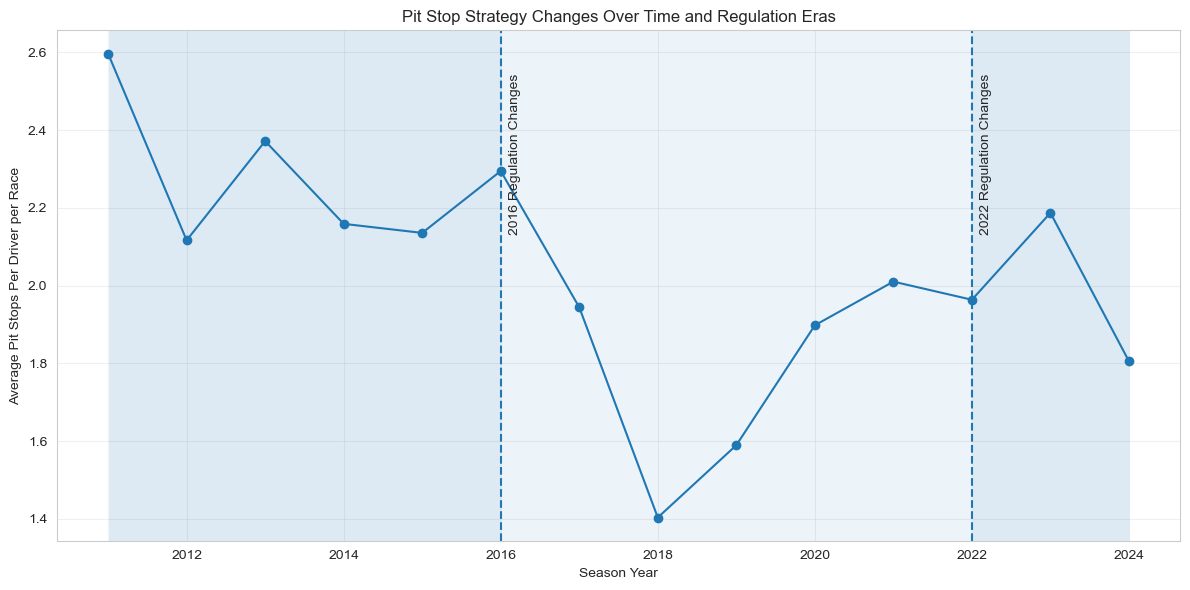

In [59]:
races_all = races.copy()
races_all["date"] = pd.to_datetime(races_all["date"])

pit_counts_all = (
    pit_stops.groupby(["raceId", "driverId"])
    .size()
    .reset_index(name="num_pitstops")
)

df_all = pit_counts_all.merge(
    results[["raceId", "driverId"]],
    on=["raceId", "driverId"],
    how="inner"
)

df_all = df_all.merge(
    races_all[["raceId", "year", "date"]],
    on="raceId",
    how="left"
)

yearly = (
    df_all.groupby("year")["num_pitstops"]
    .agg(mean="mean", median="median", n="count")
    .reset_index()
    .sort_values("year")
)

plt.figure(figsize=(12, 6))
plt.plot(yearly["year"], yearly["mean"], marker="o")
plt.xlabel("Season Year")
plt.ylabel("Average Pit Stops Per Driver per Race")
plt.title("Pit Stop Strategy Changes Over Time and Regulation Eras")
plt.grid(True, alpha=0.3)

plt.axvline(2016, linestyle="--")
plt.text(2016 + 0.1, yearly["mean"].max() * 0.98, "2016 Regulation Changes", rotation=90, va="top")

plt.axvline(2022, linestyle="--")
plt.text(2022 + 0.1, yearly["mean"].max() * 0.98, "2022 Regulation Changes", rotation=90, va="top")

xmin = yearly["year"].min()
xmax = yearly["year"].max()

plt.axvspan(xmin, 2016, alpha=0.15)
plt.axvspan(2016, 2022, alpha=0.08)
plt.axvspan(2022, xmax, alpha=0.15)

plt.tight_layout()
plt.show()

## Why did we not use data before 2016? As depicted in the above visualization

- Formula 1 strategies change a lot over time.
- Races before 2016 were run under *very different rules, with different cars, tires, and race dynamics. Including that data would mix **old era behavior* with modern strategies, which can confuse the model.
So we focused on **recent seasons that are more comparable**.

## What changed before and after 2016?

- ⁠Major regulation changes in *2014–2015* (hybrid engines)
- Different tire behavior and degradation patterns
- ⁠Different pit stop norms and race strategies. The average number pit stops per driver reduces significantly after 2015 regulation change.
- Smaller and less consistent pit stop datasets
Using very old data assumes strategies are timeless, which they are not.


In [60]:
races_filtered = races[races['year'] >= 2016].copy()
race_ids = races_filtered['raceId'].unique()

results_filtered = results[results['raceId'].isin(race_ids)].copy()
pit_stops_filtered = pit_stops[pit_stops['raceId'].isin(race_ids)].copy()
lap_times_filtered = lap_times[lap_times['raceId'].isin(race_ids)].copy()
qualifying_filtered = qualifying[qualifying['raceId'].isin(race_ids)].copy()
pitstops_per_driver_race = pit_stops_filtered.groupby(['raceId', 'driverId']).size().reset_index(name='num_pitstops')

print(f'Filtered to races from 2016 onwards.')
print(f'Total races: {len(races_filtered)}')
print(f'Date range: {races_filtered["year"].min()} to {races_filtered["year"].max()}')

Filtered to races from 2016 onwards.
Total races: 190
Date range: 2016 to 2024


## 2. Data Cleaning

In [61]:
results_clean = results_filtered.copy()
pitstops_count_clean = pitstops_per_driver_race.copy()
qualifying_clean = qualifying_filtered.copy()

print('1. Handling grid position issues...')
# Flag pit lane starts
results_clean['pit_lane_start'] = (results_clean['grid'] == 0).astype(int)
# Replace 0 with a large number (back of grid) for modeling
results_clean['grid_cleaned'] = results_clean['grid'].replace(0, 25)
print(f"   Flagged {results_clean['pit_lane_start'].sum()} pit lane starts")

print('\n2. Handling qualifying data...')
# Merge qualifying position with results
quali_positions = qualifying_clean[['raceId', 'driverId', 'position']].rename(columns={'position': 'quali_position'})
results_clean = results_clean.merge(quali_positions, on=['raceId', 'driverId'], how='left')
# If qualifying position is missing, use grid position
results_clean['quali_position'] = results_clean['quali_position'].fillna(results_clean['grid_cleaned'])
print(f"   Filled {results_clean['quali_position'].isnull().sum()} missing qualifying positions")

print('\n3. Calculating race completion...')
# Total laps per race
race_total_laps = results_clean.groupby('raceId')['laps'].max().reset_index()
race_total_laps.columns = ['raceId', 'total_race_laps']
results_clean = results_clean.merge(race_total_laps, on='raceId', how='left')
# Calculate completion percentage
results_clean['laps_completed_pct'] = (results_clean['laps'] / results_clean['total_race_laps'] * 100)
# Flag completed races (>90% distance)
results_clean['completed_race'] = (results_clean['laps_completed_pct'] >= 90).astype(int)
print(f"   Flagged {results_clean['completed_race'].sum()} completed races")

print('\n4. Removing extreme outliers...')
# Remove 6+ pit stop races
outliers_removed = pitstops_count_clean[pitstops_count_clean['num_pitstops'] >= 6]
pitstops_count_clean = pitstops_count_clean[pitstops_count_clean['num_pitstops'] < 6]
print(f"   Removed {len(outliers_removed)} samples with 6+ pit stops")
print(f"   Remaining samples: {len(pitstops_count_clean)}")

1. Handling grid position issues...
   Flagged 76 pit lane starts

2. Handling qualifying data...
   Filled 0 missing qualifying positions

3. Calculating race completion...
   Flagged 3281 completed races

4. Removing extreme outliers...
   Removed 24 samples with 6+ pit stops
   Remaining samples: 3549


## 3. Building Master Dataset

In [62]:
print('Building master dataset with proper time handling...\n')
df = pitstops_count_clean.copy()

# Merge with cleaned results
df = df.merge(
    results_clean[['raceId', 'driverId', 'constructorId', 'grid_cleaned', 'quali_position',
                   'position', 'positionOrder', 'points', 'laps', 'total_race_laps',
                   'pit_lane_start', 'completed_race', 'laps_completed_pct', 'statusId']],
    on=['raceId', 'driverId'],
    how='left'
)

# Merge with races
df = df.merge(
    races_filtered[['raceId', 'year', 'round', 'circuitId', 'date', 'name']],
    on='raceId',
    how='left'
)
df.rename(columns={'name': 'race_name'}, inplace=True)

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

# Merge with circuits
df = df.merge(
    circuits[['circuitId', 'name', 'location', 'country', 'lat', 'lng']],
    on='circuitId',
    how='left'
)
df.rename(columns={'name': 'circuit_name'}, inplace=True)

# Merge with constructors
df = df.merge(
    constructors[['constructorId', 'name', 'nationality']],
    on='constructorId',
    how='left'
)
df.rename(columns={'name': 'constructor_name', 'nationality': 'constructor_nationality'}, inplace=True)

# Merge with drivers
df = df.merge(
    drivers[['driverId', 'driverRef', 'surname', 'nationality']],
    on='driverId',
    how='left'
)
df.rename(columns={'surname': 'driver_surname', 'nationality': 'driver_nationality'}, inplace=True)

# Sort by date chronologically for time-aware features
df = df.sort_values('date').reset_index(drop=True)

print(f'Master dataset created: {df.shape}')
print(f'Date range: {df["date"].min()} to {df["date"].max()}')
print('\nDataset is sorted chronologically (required for time-aware features)!')

Building master dataset with proper time handling...

Master dataset created: (3549, 30)
Date range: 2016-03-20 00:00:00 to 2024-12-08 00:00:00

Dataset is sorted chronologically (required for time-aware features)!


# 4. EDA

PIT STOP COUNT DISTRIBUTION

Overall Pit Stop Distribution:
 1 Stops: 1467 ( 41.3%)
 2 Stops: 1350 ( 38.0%)
 3 Stops:  496 ( 14.0%)
 4 Stops:  179 (  5.0%)
 5 Stops:   57 (  1.6%)

Statistics:
 Mean:   1.88 stops
 Median: 2 stops
 Mode:   1 stops
 Std:    0.94


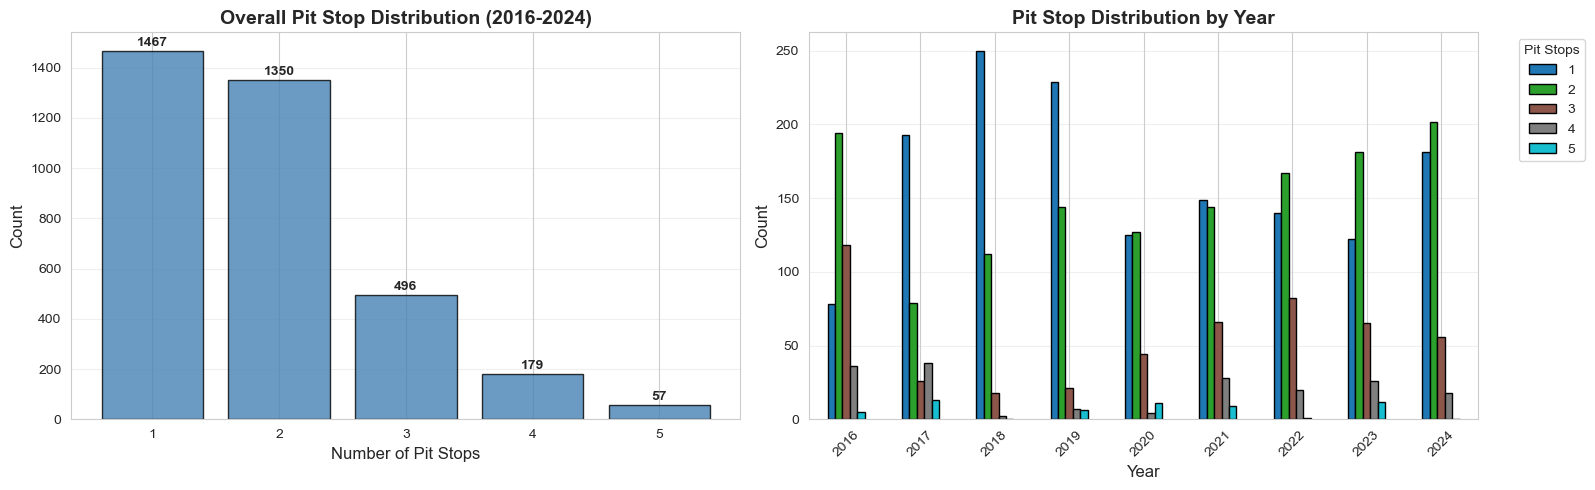

In [63]:
print("PIT STOP COUNT DISTRIBUTION")

# Overall pit stop distribution
counts = df['num_pitstops'].value_counts().sort_index()
print(f"\nOverall Pit Stop Distribution:")
for stops, count in counts.items():
    pct = count / len(df) * 100
    print(f" {stops} Stops: {count:>4} ({pct:>5.1f}%)")

print(f"\nStatistics:")
print(f" Mean:   {df['num_pitstops'].mean():.2f} stops")
print(f" Median: {df['num_pitstops'].median():.0f} stops")
print(f" Mode:   {df['num_pitstops'].mode()[0]} stops")
print(f" Std:    {df['num_pitstops'].std():.2f}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Overall distribution
axes[0].bar(counts.index, counts.values, color='steelblue', edgecolor='black', alpha=0.8)
axes[0].set_title('Overall Pit Stop Distribution (2016-2024)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Pit Stops', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(counts.values):
    axes[0].text(counts.index[i], v + 20, str(v), ha='center', fontweight='bold')

# Year-by-year trend
year_dist = df.groupby(['year', 'num_pitstops']).size().unstack(fill_value=0)
year_dist.plot(kind='bar', stacked=False, ax=axes[1], colormap='tab10', edgecolor='black')
axes[1].set_title('Pit Stop Distribution by Year', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Year', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].legend(title='Pit Stops', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

**ANALYSIS OF PIT STOP COUNT DISTRIBUTION:**

- **Overall Distribution:** The data shows that the most common number of pit stops per driver per race is 1 (41.3%), followed closely by 2 stops (38.0%). Fewer drivers make 3 or more stops, with 5 stops being very rare (1.6%).

- **Statistics:** The mean number of pit stops is approximately 1.88, which aligns with the mode (1) and median (2), confirming that the distribution is centered around one or two stops. The standard deviation of 0.94 indicates a moderate spread around the mean.

- **Year-by-Year Trend:** The stacked bar chart shows that the distribution of pit stop counts has remained relatively consistent across the years from 2016 to 2024. While there are some minor fluctuations in the counts for each number of stops per year, the overall pattern of 1 or 2 stops being the most frequent remains stable throughout the period.

TOTAL LAPS VS PIT STOPS
  Pearson correlation: 0.073 (p=0.0000)
  Mean pit stops (low lap races): 1.73
  Mean pit stops (high lap races): 1.98
  T-test p-value: 0.0000


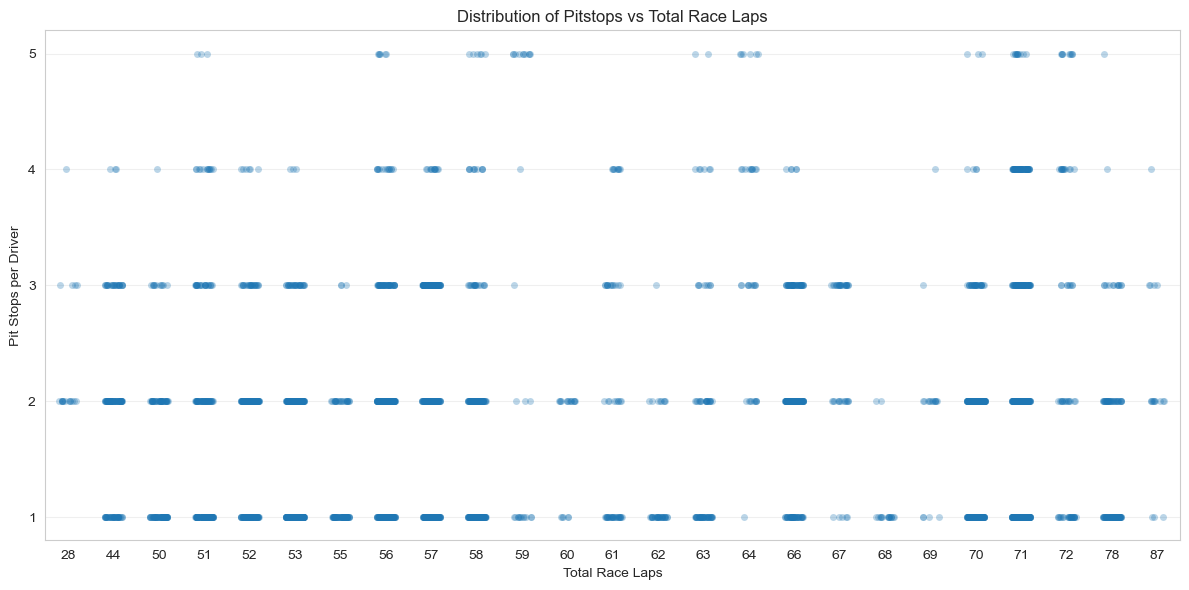

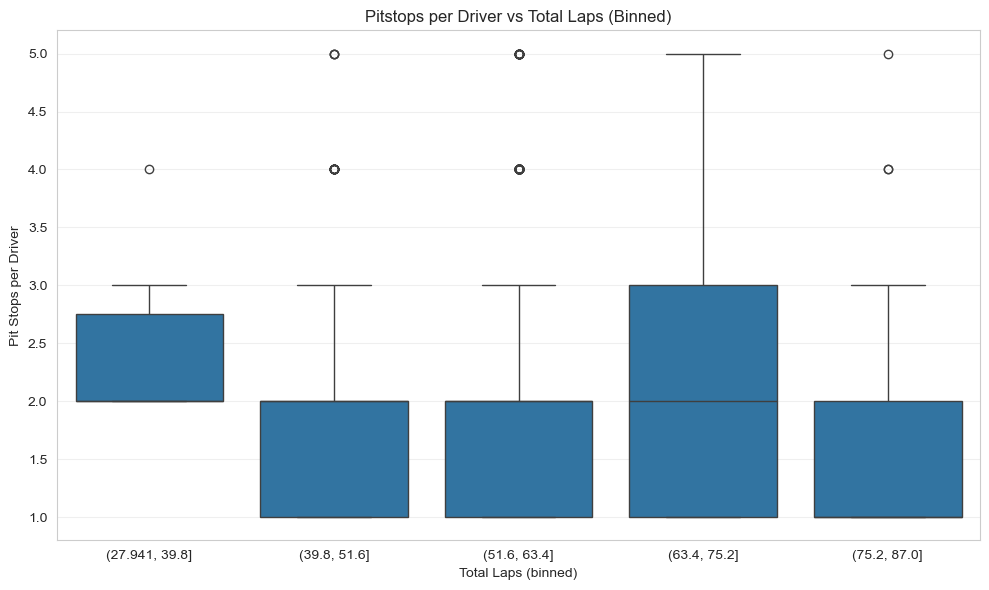


Conclusion: 
- There is a statistically significant positive correlation between total laps and number of pitstops per driver. 
- Races with more laps tend to have slightly higher pitstop counts.


In [64]:
from scipy.stats import pearsonr, ttest_ind
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

print("TOTAL LAPS VS PIT STOPS")

# Pearson correlation
corr_pearson, p_value_pearson = pearsonr(df['total_race_laps'], df['num_pitstops'])
print(f"  Pearson correlation: {corr_pearson:.3f} (p={p_value_pearson:.4f})")

# Mean pitstops grouped by high/low laps
median_laps = df['total_race_laps'].median()
low_laps = df[df['total_race_laps'] < median_laps]['num_pitstops']
high_laps = df[df['total_race_laps'] >= median_laps]['num_pitstops']
print(f"  Mean pit stops (low lap races): {low_laps.mean():.2f}")
print(f"  Mean pit stops (high lap races): {high_laps.mean():.2f}")
ttest_res = ttest_ind(high_laps, low_laps, equal_var=False)
print(f"  T-test p-value: {ttest_res.pvalue:.4f}")

# Visualization 1: Number of Pitstops vs Total Race Laps
plt.figure(figsize=(12,6))
sns.stripplot(data=df, x='total_race_laps', y='num_pitstops', jitter=0.2, alpha=0.3, color='tab:blue')
plt.xlabel('Total Race Laps')
plt.ylabel('Pit Stops per Driver')
plt.title('Distribution of Pitstops vs Total Race Laps')
plt.yticks(np.arange(df['num_pitstops'].min(), df['num_pitstops'].max()+1, 1))
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Visualization 2: Pitstops per Driver vs Total Laps (binned)
lap_bins = pd.cut(df['total_race_laps'], bins=5)  # 5 bins for clarity
plt.figure(figsize=(10,6))
sns.boxplot(x=lap_bins, y='num_pitstops', data=df)
plt.xlabel('Total Laps (binned)')
plt.ylabel('Pit Stops per Driver')
plt.title('Pitstops per Driver vs Total Laps (Binned)')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### Conclusion
if p_value_pearson < 0.05 and ttest_res.pvalue < 0.05:
    print("\nConclusion: \n- There is a statistically significant positive correlation between total laps and number of pitstops per driver. \n- Races with more laps tend to have slightly higher pitstop counts.")
else:
    print("\nConclusion: \n- There is no statistically significant evidence that races with more laps have higher pitstop counts per driver.")


CORRELATION MATRIX TO ANALYZE CORRELATION OF DIFFERENT FEATURES WITH NUM_PITSTOPS


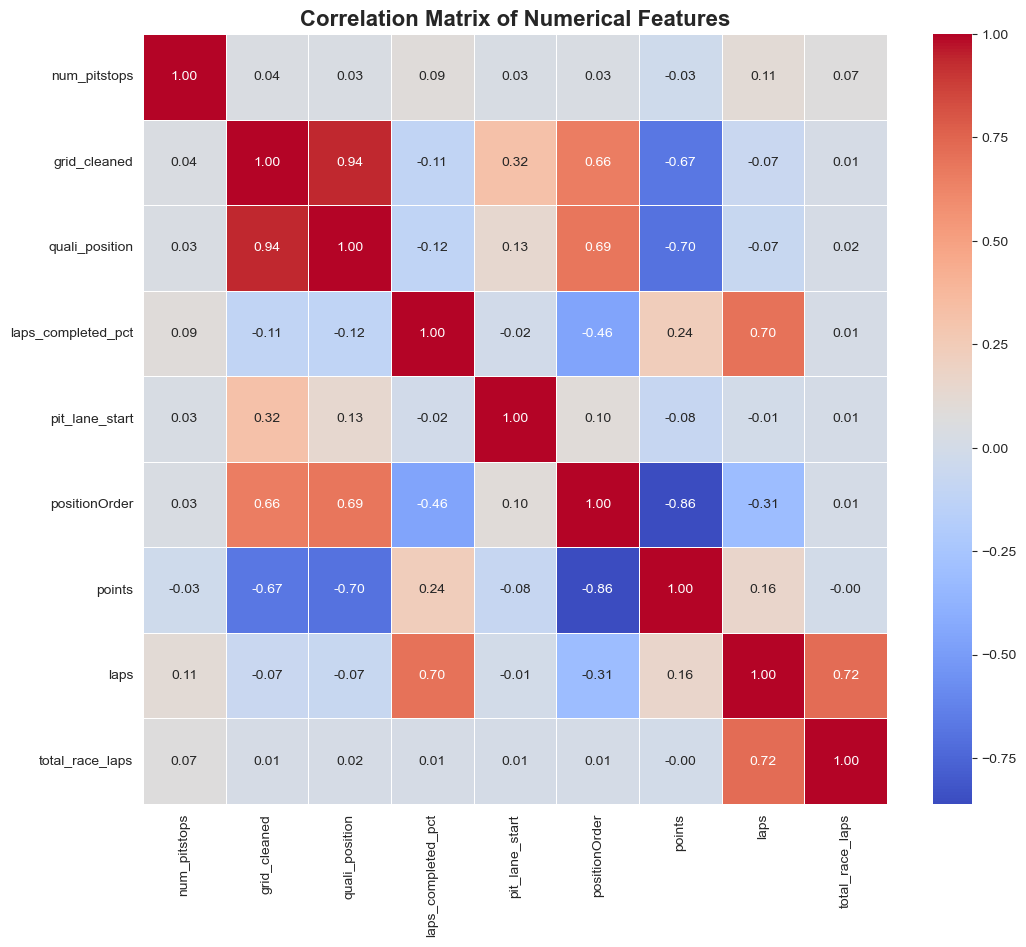

Plotted correlation matrix

Correlations with 'num_pitstops':
num_pitstops          1.000000
laps                  0.111570
laps_completed_pct    0.089172
total_race_laps       0.072747
grid_cleaned          0.041361
positionOrder         0.034803
quali_position        0.034438
pit_lane_start        0.026814
points               -0.030619
Name: num_pitstops, dtype: float64


In [65]:
print("CORRELATION MATRIX TO ANALYZE CORRELATION OF DIFFERENT FEATURES WITH NUM_PITSTOPS")

correlation_cols = ['num_pitstops', 'grid_cleaned', 'quali_position', 'laps_completed_pct',
                    'pit_lane_start', 'positionOrder', 'points', 'laps', 'total_race_laps']

corr_matrix = df[correlation_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Features', fontsize=16, fontweight='bold')
plt.show()
print("Plotted correlation matrix")
print("\nCorrelations with 'num_pitstops':")
print(corr_matrix['num_pitstops'].sort_values(ascending=False))

**ANALYSIS OF CORRELATION MATRIX:**

The correlations with num_pitstops that most influence the number of pitstops:

- **Grid Position vs Qualifying Position (corr ≈ 0.94)**  
  This is a very strong positive correlation and is expected. Grid position is largely determined by qualifying results, with minor deviations due to penalties or special rules.

- **Position Order vs Points (corr ≈ -0.86)**  
  A strong negative correlation. Lower positionOrder values correspond to better finishing positions, which yield more points. This confirms internal consistency in the dataset.

- **Laps vs Total Race Laps (corr ≈ 0.72)**  
  A strong positive correlation, as drivers who finish the race typically complete most or all laps. DNFs reduce completed laps and weaken this relationship slightly.

- **Laps Completed Percentage vs Laps (corr ≈ 0.70)**  
  Another strong and intuitive relationship. Drivers completing more laps naturally have a higher completion percentage.

- **Qualifying Position vs Points (corr ≈ -0.70)**  
  Better qualifying positions are associated with more points, though the relationship is weaker than finishing position, reflecting the influence of race dynamics and strategy.


## 4. Feature Engineering

1. **Time-aware historical averages** using expanding window
2. **Comprehensive feature set** for better predictions
3. **Clear variable names** (feature_cols_all instead of reusing feature_cols)

In [66]:
print('Creating time-aware features...\n')

def compute_historical_avg(group):
    """Compute expanding mean while excluding current race"""
    return group['num_pitstops'].expanding().mean().shift(1)

print('1. Circuit historical averages')
df['circuit_hist_avg'] = df.groupby('circuitId', group_keys=False).apply(
    compute_historical_avg
)

overall_avg = df['num_pitstops'].mean()
df['circuit_hist_avg'] = df['circuit_hist_avg'].fillna(overall_avg)
print(f'   Created (fillna with overall avg: {overall_avg:.2f})\n')

print('2. Constructor historical averages')
df['constructor_hist_avg'] = df.groupby('constructorId')['num_pitstops']\
    .transform(lambda x: x.expanding().mean().shift(1))
df['constructor_hist_avg'] = df['constructor_hist_avg'].fillna(overall_avg)
print('   Created\n')

print('3. Driver historical averages')
df['driver_hist_avg'] = df.groupby('driverId')['num_pitstops']\
    .transform(lambda x: x.expanding().mean().shift(1))
df['driver_hist_avg'] = df['driver_hist_avg'].fillna(overall_avg)
print('    Created')

print('\n4. Renaming columns for clarity')
df.rename(columns={
    'lat': 'circuit_latitude',
    'lng': 'circuit_longitude',
    'grid_cleaned': 'grid_position',
    'positionOrder': 'finishing_position',
    'round': 'race_round'
}, inplace=True)
print('   Renamed: lat→circuit_latitude, lng→circuit_longitude')
print('   Renamed: grid_cleaned→grid_position, positionOrder→finishing_position')
print('   Renamed: round→race_round\n')

print('5. Creating additional features')

df['grid_penalty'] = df['grid_position'] - df['quali_position']
df['has_grid_penalty'] = (df['grid_penalty'] > 0).astype(int)

df['positions_gained'] = df['grid_position'] - df['finishing_position']

df['scored_points'] = (df['points'] > 0).astype(int)

df['race_in_season_pct'] = df['race_round'] / df.groupby('year')['race_round'].transform('max') * 100

df['grid_category'] = pd.cut(
    df['grid_position'],
    bins=[0, 5, 10, 15, 25],
    labels=['front', 'midfield', 'back', 'very_back']
)

df['circuit_race_count'] = df.groupby('circuitId').cumcount() + 1

print('   Grid penalty features created')
print('   Position change features created')
print('   Temporal and categorical features created\n')

print('6. Creating classification target')
df['pitstop_class_3'] = pd.cut(
    df['num_pitstops'],
    bins=[0, 1, 2, 100],
    labels=[1, 2, 3],
    include_lowest=True
).astype(int)
print('   3-class target: 1-stop, 2-stop, 3+ stops\n')

print(f'Feature engineering complete!')
print(f'Final dataset shape: {df.shape}')

Creating time-aware features...

1. Circuit historical averages
   Created (fillna with overall avg: 1.88)

2. Constructor historical averages
   Created

3. Driver historical averages
    Created

4. Renaming columns for clarity
   Renamed: lat→circuit_latitude, lng→circuit_longitude
   Renamed: grid_cleaned→grid_position, positionOrder→finishing_position
   Renamed: round→race_round

5. Creating additional features
   Grid penalty features created
   Position change features created
   Temporal and categorical features created

6. Creating classification target
   3-class target: 1-stop, 2-stop, 3+ stops

Feature engineering complete!
Final dataset shape: (3549, 41)


## 5. Feature Selection

### Using distinct variable names to avoid confusion:
- `feature_cols_all`: Complete feature set for best performance
- `numerical_features`: Features that need scaling
- `categorical_features`: Features that need encoding

In [67]:
feature_cols_all = [
    'grid_position',
    'quali_position',
    'has_grid_penalty',
    
    'circuit_hist_avg',
    'constructor_hist_avg',
    'driver_hist_avg',
    
    'total_race_laps',
    'race_in_season_pct',
    'race_round',
    
    # Circuit features
    'circuit_latitude',
    'circuit_longitude',
    'circuit_race_count',
    
    'year',

    'pit_lane_start',
    'laps_completed_pct'
]

numerical_features = [
    'grid_position', 'quali_position',
    'circuit_hist_avg', 'constructor_hist_avg', 'driver_hist_avg',
    'total_race_laps', 'race_in_season_pct', 'race_round',
    'circuit_latitude', 'circuit_longitude', 'circuit_race_count',
    'year', 'laps_completed_pct'
]

categorical_features = [
    'has_grid_penalty',
    'pit_lane_start'
]

missing_features = [col for col in feature_cols_all if col not in df.columns]
if missing_features:
    print(f'!!WARNING: Missing features!!: {missing_features}')
else:
    print(f'All {len(feature_cols_all)} features are available')

X = df[feature_cols_all].copy()
y_reg = df['num_pitstops'].copy()
y_class = df['pitstop_class_3'].copy()

print(f'\nFeature matrix shape: {X.shape}')
print(f'Regression target shape: {y_reg.shape}')
print(f'Classification target shape: {y_class.shape}')
print(f'\nTarget distribution:')
print(y_class.value_counts().sort_index())

All 15 features are available

Feature matrix shape: (3549, 15)
Regression target shape: (3549,)
Classification target shape: (3549,)

Target distribution:
pitstop_class_3
1    1467
2    1350
3     732
Name: count, dtype: int64


## 6. Train/Validation/Test Split

### Using time-based split (no future data leakage)
- Train: 2016-2022 (older data)
- Validation: 2022-2023 (middle data)
- Test: 2023-2024 (most recent data)

This is more realistic than a random split

In [68]:
print('TIME-BASED TRAIN/VALIDATION/TEST SPLIT...')

# Time-based split (70% train, 15% val, 15% test)
df_sorted = df.sort_values('date').reset_index(drop=True)
n = len(df_sorted)
train_end = int(0.70 * n)
val_end = int(0.85 * n)

train_df = df_sorted.iloc[:train_end].copy()
val_df = df_sorted.iloc[train_end:val_end].copy()
test_df = df_sorted.iloc[val_end:].copy()

# Extract features and targets
X_train = train_df[feature_cols_all].copy()
X_val = val_df[feature_cols_all].copy()
X_test = test_df[feature_cols_all].copy()

# Regression targets
y_train_reg = train_df['num_pitstops'].copy()
y_val_reg = val_df['num_pitstops'].copy()
y_test_reg = test_df['num_pitstops'].copy()

# Classification targets
y_train_class = train_df['pitstop_class_3'].copy()
y_val_class = val_df['pitstop_class_3'].copy()
y_test_class = test_df['pitstop_class_3'].copy()

print(f'\nData Split:')
print(f'   Train: {len(train_df):>4} samples ({len(train_df)/n*100:.1f}%)')
print(f'   Val:   {len(val_df):>4} samples ({len(val_df)/n*100:.1f}%)')
print(f'   Test:  {len(test_df):>4} samples ({len(test_df)/n*100:.1f}%)')

print(f'\nDate Range:')
print(f'   Train: {train_df["date"].min().date()} to {train_df["date"].max().date()}')
print(f'   Val:   {val_df["date"].min().date()} to {val_df["date"].max().date()}')
print(f'   Test:  {test_df["date"].min().date()} to {test_df["date"].max().date()}')

TIME-BASED TRAIN/VALIDATION/TEST SPLIT...

Data Split:
   Train: 2484 samples (70.0%)
   Val:    532 samples (15.0%)
   Test:   533 samples (15.0%)

Date Range:
   Train: 2016-03-20 to 2022-07-24
   Val:   2022-07-24 to 2023-10-22
   Test:  2023-10-22 to 2024-12-08


---
# PART A: MODELS WITH CHRONOLOGICAL SPLIT
---

## A1. Pit Stop LAP NUMBER Regression

In [69]:
# Create Pit Stop Lap Dataset
print('CREATING PIT STOP LAP PREDICTION DATASET:\n')

pit_stops_df = pit_stops_filtered.copy()
pit_stops_df['duration'] = pd.to_numeric(pit_stops_df['duration'], errors='coerce')
pit_stops_df = pit_stops_df.merge(races_filtered[['raceId', 'year', 'round', 'circuitId', 'date', 'name']], on='raceId', how='left')
pit_stops_df['date'] = pd.to_datetime(pit_stops_df['date'])
pit_stops_df = pit_stops_df.merge(circuits[['circuitId', 'lat', 'lng', 'alt']], on='circuitId', how='left')
pit_stops_df = pit_stops_df.merge(results_clean[['raceId', 'driverId', 'constructorId', 'grid_cleaned', 'laps', 'total_race_laps', 'quali_position']], on=['raceId', 'driverId'], how='left')

pit_stops_df = pit_stops_df.sort_values(['date', 'raceId', 'driverId', 'stop']).reset_index(drop=True)
pit_stops_df['alt'] = pit_stops_df['alt'].fillna(pit_stops_df['alt'].median())
pit_stops_df['grid_cleaned'] = pit_stops_df['grid_cleaned'].fillna(20)
pit_stops_df['quali_position'] = pit_stops_df['quali_position'].fillna(pit_stops_df['grid_cleaned'])
pit_stops_df['total_race_laps'] = pit_stops_df['total_race_laps'].fillna(pit_stops_df['total_race_laps'].median())

overall_avg_lap = pit_stops_df['lap'].mean()
pit_stops_df['circuit_hist_avg_lap'] = pit_stops_df.groupby('circuitId')['lap'].transform(lambda x: x.expanding().mean().shift(1)).fillna(overall_avg_lap)
pit_stops_df['constructor_hist_avg_lap'] = pit_stops_df.groupby('constructorId')['lap'].transform(lambda x: x.expanding().mean().shift(1)).fillna(overall_avg_lap)
pit_stops_df['driver_hist_avg_lap'] = pit_stops_df.groupby('driverId')['lap'].transform(lambda x: x.expanding().mean().shift(1)).fillna(overall_avg_lap)
pit_stops_df['season_progress'] = pit_stops_df['round'] / pit_stops_df.groupby('year')['round'].transform('max')
pit_stops_df['is_new_regs'] = (pit_stops_df['year'] >= 2022).astype(int)

print(f'Pit stops dataset: {len(pit_stops_df)} rows')
print(f'Overall avg pit stop lap: {overall_avg_lap:.1f}')

CREATING PIT STOP LAP PREDICTION DATASET:

Pit stops dataset: 6803 rows
Overall avg pit stop lap: 24.9


In [70]:
# Train Lap Prediction Model (Chronological)
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

lap_features = ['stop', 'grid_cleaned', 'quali_position', 'total_race_laps', 'year', 'round',
    'lat', 'lng', 'alt', 'circuit_hist_avg_lap', 'constructor_hist_avg_lap',
    'driver_hist_avg_lap', 'season_progress', 'is_new_regs']

lap_df = pit_stops_df.dropna(subset=['lap'] + lap_features).sort_values('date').reset_index(drop=True)
n_lap = len(lap_df)
train_end_lap, val_end_lap = int(0.70 * n_lap), int(0.85 * n_lap)

X_train_lap = lap_df.iloc[:train_end_lap][lap_features]
X_val_lap = lap_df.iloc[train_end_lap:val_end_lap][lap_features]
X_test_lap = lap_df.iloc[val_end_lap:][lap_features]
y_train_lap = lap_df.iloc[:train_end_lap]['lap']
y_val_lap = lap_df.iloc[train_end_lap:val_end_lap]['lap']
y_test_lap = lap_df.iloc[val_end_lap:]['lap']

print('A1. LAP NUMBER REGRESSION (Chronological Split):\n')

print(f'Train: {len(X_train_lap)}, Val: {len(X_val_lap)}, Test: {len(X_test_lap)}')

scaler_lap = StandardScaler()
X_train_lap_scaled = scaler_lap.fit_transform(X_train_lap)
X_val_lap_scaled = scaler_lap.transform(X_val_lap)
X_test_lap_scaled = scaler_lap.transform(X_test_lap)

lap_regressor = RandomForestRegressor(n_estimators=100, max_depth=8, min_samples_split=30, min_samples_leaf=15, random_state=RANDOM_STATE, n_jobs=-1)
lap_regressor.fit(X_train_lap_scaled, y_train_lap)

train_r2_lap = r2_score(y_train_lap, lap_regressor.predict(X_train_lap_scaled))
val_r2_lap = r2_score(y_val_lap, lap_regressor.predict(X_val_lap_scaled))
test_r2_lap = r2_score(y_test_lap, lap_regressor.predict(X_test_lap_scaled))
test_mae_lap = mean_absolute_error(y_test_lap, lap_regressor.predict(X_test_lap_scaled))
baseline_mae_lap = mean_absolute_error(y_test_lap, np.full_like(y_test_lap, y_train_lap.mean(), dtype=float))

print(f'\nR-Squared: Train={train_r2_lap:.3f}, Val={val_r2_lap:.3f}, Test={test_r2_lap:.3f}')
print(f'Test MAE: {test_mae_lap:.2f} laps')
print(f'Baseline MAE: {baseline_mae_lap:.2f} laps')
print(f'Improvement over baseline: {(baseline_mae_lap - test_mae_lap)/baseline_mae_lap*100:.1f}%')

A1. LAP NUMBER REGRESSION (Chronological Split):

Train: 4762, Val: 1020, Test: 1021

R-Squared: Train=0.667, Val=0.397, Test=0.313
Test MAE: 9.13 laps
Baseline MAE: 11.63 laps
Improvement over baseline: 21.5%


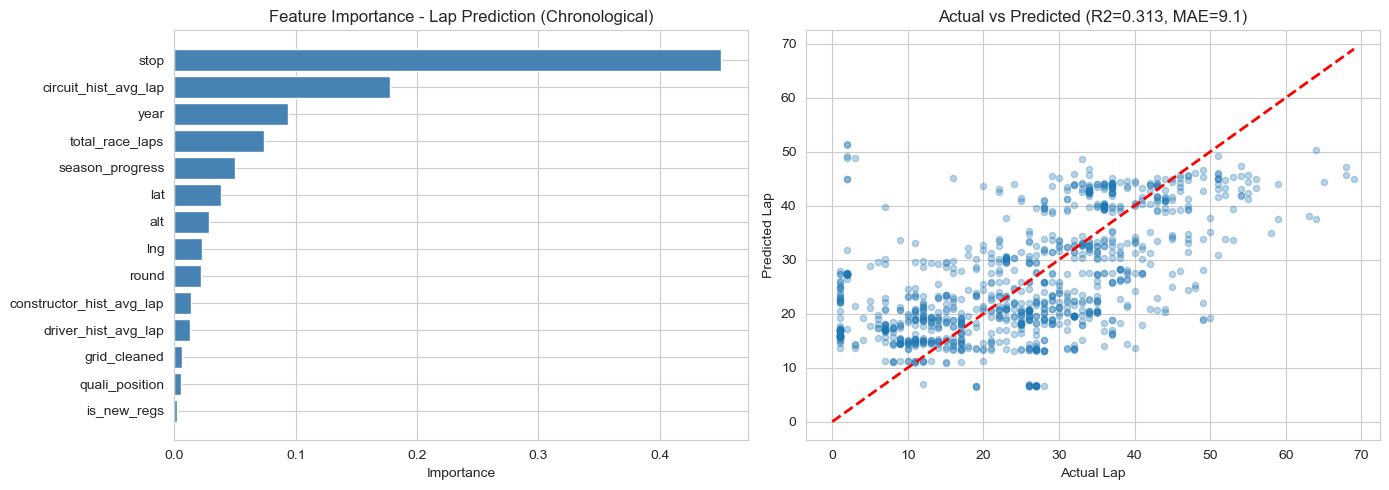

In [71]:
# Visualization for Lap Prediction
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Feature importance
importance = pd.DataFrame({'Feature': lap_features, 'Importance': lap_regressor.feature_importances_})
importance = importance.sort_values('Importance', ascending=True)
axes[0].barh(importance['Feature'], importance['Importance'], color='steelblue')
axes[0].set_xlabel('Importance')
axes[0].set_title('Feature Importance - Lap Prediction (Chronological)')

# Actual vs Predicted
y_test_pred_lap = lap_regressor.predict(X_test_lap_scaled)
axes[1].scatter(y_test_lap, y_test_pred_lap, alpha=0.3, s=20)
max_val = max(y_test_lap.max(), max(y_test_pred_lap))
axes[1].plot([0, max_val], [0, max_val], 'r--', lw=2)
axes[1].set_xlabel('Actual Lap')
axes[1].set_ylabel('Predicted Lap')
axes[1].set_title(f'Actual vs Predicted (R2={test_r2_lap:.3f}, MAE={test_mae_lap:.1f})')

plt.tight_layout()
plt.show()

**Analysis of Visualization for Lap Prediction**

- The `stop` feature is by far the most important predictor. This means the model relies heavily on whether it is predicting the first, second, or later pit stop.

- `circuit_hist_avg_lap` is the second most important feature, indicating that circuits have characteristic pit windows that generalize across seasons.

- `year`, `total_race_laps`, and `season_progress` contribute some signal, suggesting gradual evolution of strategies over time and dependence on race length.

- `lat`, `lng`, and `alt` have minor importance, meaning track geography alone does not strongly determine pit timing once circuit history is known.

- `driver_hist_avg_lap`, `constructor_hist_avg_lap`, `grid_cleaned`, and `quali_position` contribute very little. This suggests pit timing is more standardized than driver-specific in this formulation.

- An R^2 of 0.313 means the model explains about 31% of the variance in pit stop lap timing. The scatter shows that early pit stops are often overpredicted and late pit stops are underpredicted.

---
## A2. Pit Stop Count Classification (XGBoost)

Using XGBoost classifier with train+val combined for better handling of distribution shift.

In [72]:
print('CREATING ENHANCED FEATURES FOR CLASSIFICATION:\n')

df['is_2022_plus'] = (df['year'] >= 2022).astype(int)
overall_avg_stops = df['num_pitstops'].mean()

# Recent rolling averages (capture regime changes better)
df_temp = df.sort_values(['circuitId', 'date'])
df['circuit_recent_avg'] = df_temp.groupby('circuitId')['num_pitstops'].transform(lambda x: x.rolling(20, min_periods=1).mean().shift(1)).fillna(overall_avg_stops)

df_temp = df.sort_values(['constructorId', 'date'])
df['constructor_recent_avg'] = df_temp.groupby('constructorId')['num_pitstops'].transform(lambda x: x.rolling(15, min_periods=1).mean().shift(1)).fillna(overall_avg_stops)

df_temp = df.sort_values(['driverId', 'date'])
df['driver_recent_avg'] = df_temp.groupby('driverId')['num_pitstops'].transform(lambda x: x.rolling(10, min_periods=1).mean().shift(1)).fillna(overall_avg_stops)

df = df.sort_values('date').reset_index(drop=True)
df['global_recent_avg'] = df['num_pitstops'].rolling(100, min_periods=1).mean().shift(1).fillna(overall_avg_stops)

# Target variable (0, 1, 2 for XGBoost)
df['pitstop_class'] = pd.cut(df['num_pitstops'], bins=[0, 1, 2, 100], labels=[0, 1, 2], include_lowest=True).astype(int)

print(f'Class distribution: {dict(df["pitstop_class"].value_counts(normalize=True).sort_index().round(3))}')

CREATING ENHANCED FEATURES FOR CLASSIFICATION:

Class distribution: {0: 0.413, 1: 0.38, 2: 0.206}


In [73]:
# Train XGBoost Classifier (Chronological - Train+Val Combined)
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

print('A2. XGBOOST CLASSIFICATION (Chronological Split):\n')

clf_features = ['grid_position', 'quali_position', 'total_race_laps', 'race_round',
    'circuit_recent_avg', 'constructor_recent_avg', 'driver_recent_avg', 'global_recent_avg',
    'circuit_hist_avg', 'constructor_hist_avg', 'driver_hist_avg', 'race_in_season_pct',
    'is_2022_plus', 'circuit_race_count', 'year']
clf_features_available = [f for f in clf_features if f in df.columns]
print(f'Using {len(clf_features_available)} features')

# Chronological split - combine train+val for more 2022+ data
df = df.sort_values('date').reset_index(drop=True)
n = len(df)
train_end = int(0.70 * n)
val_end = int(0.85 * n)

# Combine train + val (85%) for training
trainval_df = df.iloc[:val_end]
test_df_clf = df.iloc[val_end:]

X_trainval = trainval_df[clf_features_available]
X_test_clf = test_df_clf[clf_features_available]
y_trainval = trainval_df['pitstop_class']
y_test_clf = test_df_clf['pitstop_class']

print(f'\nTrain+Val: {len(X_trainval)} samples (85%)')
print(f'Test: {len(X_test_clf)} samples (15%)')
print(f'\nClass distribution:')
print(f'- Train+Val: {dict(y_trainval.value_counts(normalize=True).sort_index().round(3))}')
print(f'- Test: {dict(y_test_clf.value_counts(normalize=True).sort_index().round(3))}')

# Scale features
scaler_clf = StandardScaler()
X_trainval_scaled = scaler_clf.fit_transform(X_trainval)
X_test_clf_scaled = scaler_clf.transform(X_test_clf)

# XGBoost Classifier
xgb_clf_chrono = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=5,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=RANDOM_STATE,
    eval_metric='mlogloss',
    use_label_encoder=False
)

print('\nTraining XGBoost Classifier...')
xgb_clf_chrono.fit(X_trainval_scaled, y_trainval)

# Evaluate
train_acc_clf = accuracy_score(y_trainval, xgb_clf_chrono.predict(X_trainval_scaled))
test_acc_clf = accuracy_score(y_test_clf, xgb_clf_chrono.predict(X_test_clf_scaled))
test_f1_clf = f1_score(y_test_clf, xgb_clf_chrono.predict(X_test_clf_scaled), average='weighted')
baseline_clf = (y_test_clf == y_test_clf.mode()[0]).mean()

print('\n\nXGBOOST CLASSIFICATION RESULTS (Chronological):\n')

print(f'Train Accuracy: {train_acc_clf*100:.1f}%')
print(f'Test Accuracy:  {test_acc_clf*100:.1f}%')
print(f'Test F1 Score:  {test_f1_clf:.3f}')
print(f'\nBaseline (most frequent class): {baseline_clf*100:.1f}%')
print(f'Improvement: {(test_acc_clf - baseline_clf)*100:+.1f} percentage points')

A2. XGBOOST CLASSIFICATION (Chronological Split):

Using 15 features

Train+Val: 3016 samples (85%)
Test: 533 samples (15%)

Class distribution:
- Train+Val: {0: 0.422, 1: 0.366, 2: 0.212}
- Test: {0: 0.362, 1: 0.463, 2: 0.174}

Training XGBoost Classifier...


XGBOOST CLASSIFICATION RESULTS (Chronological):

Train Accuracy: 78.1%
Test Accuracy:  47.5%
Test F1 Score:  0.475

Baseline (most frequent class): 46.3%
Improvement: +1.1 percentage points


Classification Report:

              precision    recall  f1-score   support

      1-stop       0.54      0.57      0.55       193
      2-stop       0.49      0.40      0.44       247
     3+-stop       0.35      0.47      0.40        93

    accuracy                           0.47       533
   macro avg       0.46      0.48      0.47       533
weighted avg       0.48      0.47      0.47       533



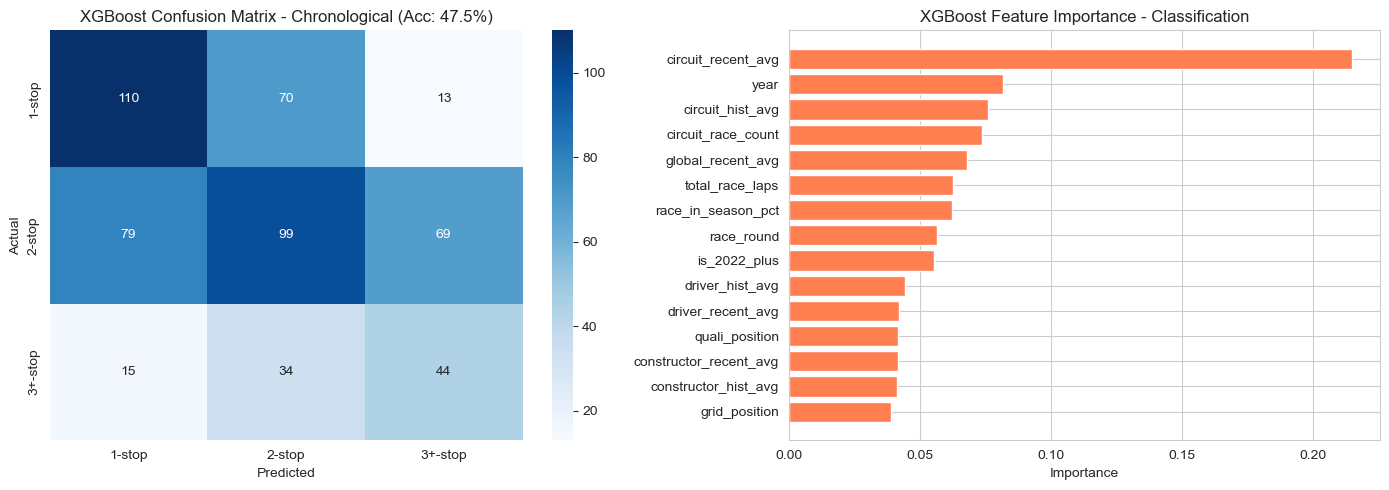

In [74]:
# Classification Report and Visualization
y_pred_clf = xgb_clf_chrono.predict(X_test_clf_scaled)

print('Classification Report:\n')
print(classification_report(y_test_clf, y_pred_clf, target_names=['1-stop', '2-stop', '3+-stop']))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
cm = confusion_matrix(y_test_clf, y_pred_clf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['1-stop', '2-stop', '3+-stop'], yticklabels=['1-stop', '2-stop', '3+-stop'])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title(f'XGBoost Confusion Matrix - Chronological (Acc: {test_acc_clf*100:.1f}%)')

# Feature Importance
importance_clf = pd.DataFrame({'Feature': clf_features_available, 'Importance': xgb_clf_chrono.feature_importances_})
importance_clf = importance_clf.sort_values('Importance', ascending=True)
axes[1].barh(importance_clf['Feature'], importance_clf['Importance'], color='coral')
axes[1].set_xlabel('Importance')
axes[1].set_title('XGBoost Feature Importance - Classification')

plt.tight_layout()
plt.show()

**Analysis:**
<br>

- The chronological XGBoost classifier achieves approximately 47.5% accuracy, exceeding random chance but indicating limited predictability using pre-race and historical features alone. 

- Circuit-level historical and recent averages dominate feature importance, highlighting that pit stop strategy is largely driven by track characteristics and evolving season trends rather than driver-specific factors. 

- Misclassifications primarily occur between adjacent strategy classes, especially 2 stop versus 3+ stop races, reflecting inherent strategic ambiguity rather than model failure.

---
# PART B: MODELS WITH RANDOM SHUFFLE SPLIT
---

Same models but with random train/test split for comparison.

In [75]:
# B1: Lap Regression (Random Split)
from sklearn.model_selection import train_test_split

print('B1. LAP NUMBER REGRESSION (Random Split):\n')

X_lap_all, y_lap_all = lap_df[lap_features], lap_df['lap']
X_train_lap_r, X_temp, y_train_lap_r, y_temp = train_test_split(X_lap_all, y_lap_all, test_size=0.30, random_state=RANDOM_STATE)
X_val_lap_r, X_test_lap_r, y_val_lap_r, y_test_lap_r = train_test_split(X_temp, y_temp, test_size=0.50, random_state=RANDOM_STATE)

print(f'Train: {len(X_train_lap_r)}, Val: {len(X_val_lap_r)}, Test: {len(X_test_lap_r)}')

scaler_lap_r = StandardScaler()
X_train_lap_r_scaled = scaler_lap_r.fit_transform(X_train_lap_r)
X_test_lap_r_scaled = scaler_lap_r.transform(X_test_lap_r)

lap_reg_rand = RandomForestRegressor(n_estimators=100, max_depth=8, min_samples_split=30, min_samples_leaf=15, random_state=RANDOM_STATE, n_jobs=-1)
lap_reg_rand.fit(X_train_lap_r_scaled, y_train_lap_r)

train_r2_lap_rand = r2_score(y_train_lap_r, lap_reg_rand.predict(X_train_lap_r_scaled))
test_r2_lap_rand = r2_score(y_test_lap_r, lap_reg_rand.predict(X_test_lap_r_scaled))
test_mae_lap_rand = mean_absolute_error(y_test_lap_r, lap_reg_rand.predict(X_test_lap_r_scaled))

print(f'\nR-Squared: Train={train_r2_lap_rand:.3f}, Test={test_r2_lap_rand:.3f}')
print(f'Test MAE: {test_mae_lap_rand:.2f} laps')

B1. LAP NUMBER REGRESSION (Random Split):

Train: 4762, Val: 1020, Test: 1021

R-Squared: Train=0.644, Test=0.565
Test MAE: 7.66 laps


In [76]:
# B2: XGBoost Classification (Random Split)
print('B2. XGBOOST CLASSIFICATION (Random Split):\n')

X_clf_all = df[clf_features_available]
y_clf_all = df['pitstop_class']

X_train_clf_r, X_temp, y_train_clf_r, y_temp = train_test_split(
    X_clf_all, y_clf_all, test_size=0.30, random_state=RANDOM_STATE, stratify=y_clf_all)
X_val_clf_r, X_test_clf_r, y_val_clf_r, y_test_clf_r = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=RANDOM_STATE, stratify=y_temp)

print(f'Train: {len(X_train_clf_r)}, Val: {len(X_val_clf_r)}, Test: {len(X_test_clf_r)}')

scaler_clf_r = StandardScaler()
X_train_clf_r_scaled = scaler_clf_r.fit_transform(X_train_clf_r)
X_test_clf_r_scaled = scaler_clf_r.transform(X_test_clf_r)

# XGBoost with same hyperparameters
xgb_clf_rand = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=5,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=RANDOM_STATE,
    eval_metric='mlogloss',
    use_label_encoder=False
)

print('\nTraining XGBoost Classifier...')
xgb_clf_rand.fit(X_train_clf_r_scaled, y_train_clf_r)

train_acc_rand = accuracy_score(y_train_clf_r, xgb_clf_rand.predict(X_train_clf_r_scaled))
test_acc_rand = accuracy_score(y_test_clf_r, xgb_clf_rand.predict(X_test_clf_r_scaled))
test_f1_rand = f1_score(y_test_clf_r, xgb_clf_rand.predict(X_test_clf_r_scaled), average='weighted')

print('\n\nXGBOOST CLASSIFICATION RESULTS (Random Split):\n')
print(f'Train Accuracy: {train_acc_rand*100:.1f}%')
print(f'Test Accuracy:  {test_acc_rand*100:.1f}%')
print(f'Test F1 Score:  {test_f1_rand:.3f}')

print('\nClassification Report:')
y_pred_rand = xgb_clf_rand.predict(X_test_clf_r_scaled)
print(classification_report(y_test_clf_r, y_pred_rand, target_names=['1-stop', '2-stop', '3+-stop']))

B2. XGBOOST CLASSIFICATION (Random Split):

Train: 2484, Val: 532, Test: 533

Training XGBoost Classifier...


XGBOOST CLASSIFICATION RESULTS (Random Split):

Train Accuracy: 79.0%
Test Accuracy:  64.4%
Test F1 Score:  0.642

Classification Report:
              precision    recall  f1-score   support

      1-stop       0.73      0.74      0.74       220
      2-stop       0.57      0.63      0.60       203
     3+-stop       0.61      0.48      0.54       110

    accuracy                           0.64       533
   macro avg       0.64      0.62      0.62       533
weighted avg       0.64      0.64      0.64       533



In [77]:
print('FINAL MODEL COMPARISON\n')

print('Model                                    Train Score    Test Score     Metric')
print('---------------------------------------------------------------------------------')
print(f'A1: Lap Regression (Chronological)       R2: {train_r2_lap:.3f}       R2: {test_r2_lap:.3f}        R-Squared')
print(f'B1: Lap Regression (Random)              R2: {train_r2_lap_rand:.3f}       R2: {test_r2_lap_rand:.3f}        R-Squared')
print(f'A2: XGBoost Classification (Chrono)      Acc: {train_acc_clf*100:.1f}%      Acc: {test_acc_clf*100:.1f}%       Accuracy')
print(f'B2: XGBoost Classification (Random)      Acc: {train_acc_rand*100:.1f}%      Acc: {test_acc_rand*100:.1f}%       Accuracy')
print('\n')
print('KEY INSIGHTS:')
print('1. Random split shows higher test scores (no temporal distribution shift)')
print('2. Chronological split is more realistic for actual deployment')
print('3. XGBoost handles the distribution shift better than simpler models')
print(f'4. Chronological classification: {test_acc_clf*100:.1f}% vs {baseline_clf*100:.1f}% baseline')

FINAL MODEL COMPARISON

Model                                    Train Score    Test Score     Metric
---------------------------------------------------------------------------------
A1: Lap Regression (Chronological)       R2: 0.667       R2: 0.313        R-Squared
B1: Lap Regression (Random)              R2: 0.644       R2: 0.565        R-Squared
A2: XGBoost Classification (Chrono)      Acc: 78.1%      Acc: 47.5%       Accuracy
B2: XGBoost Classification (Random)      Acc: 79.0%      Acc: 64.4%       Accuracy


KEY INSIGHTS:
1. Random split shows higher test scores (no temporal distribution shift)
2. Chronological split is more realistic for actual deployment
3. XGBoost handles the distribution shift better than simpler models
4. Chronological classification: 47.5% vs 46.3% baseline


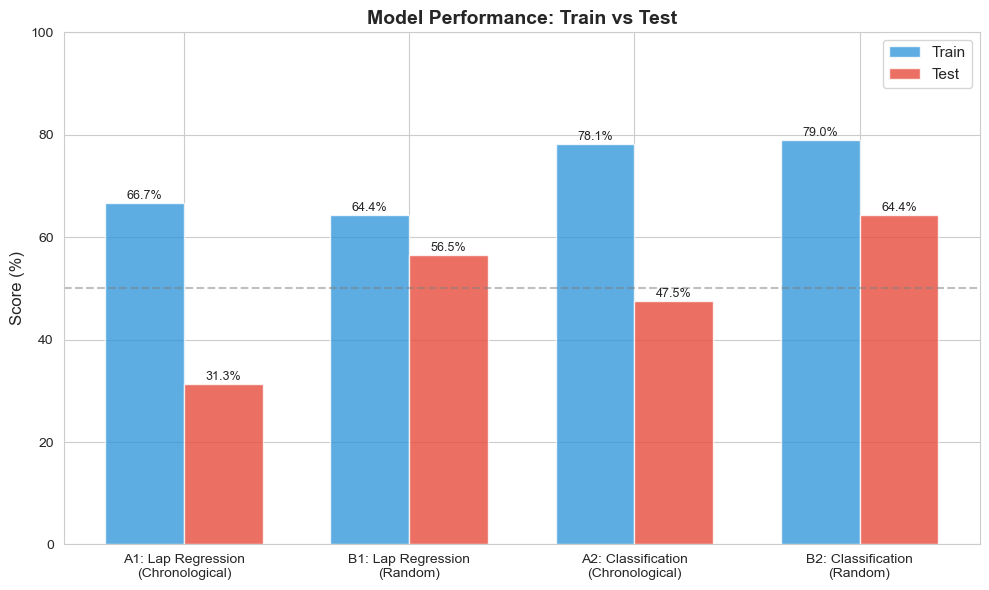

KEY TAKEAWAYS: 

- Random split shows higher test scores because it mixes all years. 
- Chronological split is harder but more realistic for real-world predictions.


In [78]:
# Model Performance Comparision
fig, ax = plt.subplots(figsize=(10, 6))

models = ['A1: Lap Regression\n(Chronological)', 'B1: Lap Regression\n(Random)', 
          'A2: Classification\n(Chronological)', 'B2: Classification\n(Random)']
train_scores = [train_r2_lap * 100, train_r2_lap_rand * 100, train_acc_clf * 100, train_acc_rand * 100]
test_scores = [test_r2_lap * 100, test_r2_lap_rand * 100, test_acc_clf * 100, test_acc_rand * 100]

x = np.arange(len(models))
width = 0.35

bars1 = ax.bar(x - width/2, train_scores, width, label='Train', color='#3498db', alpha=0.8)
bars2 = ax.bar(x + width/2, test_scores, width, label='Test', color='#e74c3c', alpha=0.8)

ax.set_ylabel('Score (%)', fontsize=12)
ax.set_title('Model Performance: Train vs Test', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=10)
ax.legend(fontsize=11)
ax.set_ylim(0, 100)

for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', fontsize=9)
for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', fontsize=9)

ax.axhline(y=50, color='gray', linestyle='--', alpha=0.5, label='50% baseline')
plt.tight_layout()
plt.show()

print("KEY TAKEAWAYS: \n\n- Random split shows higher test scores because it mixes all years. \n- Chronological split is harder but more realistic for real-world predictions.")

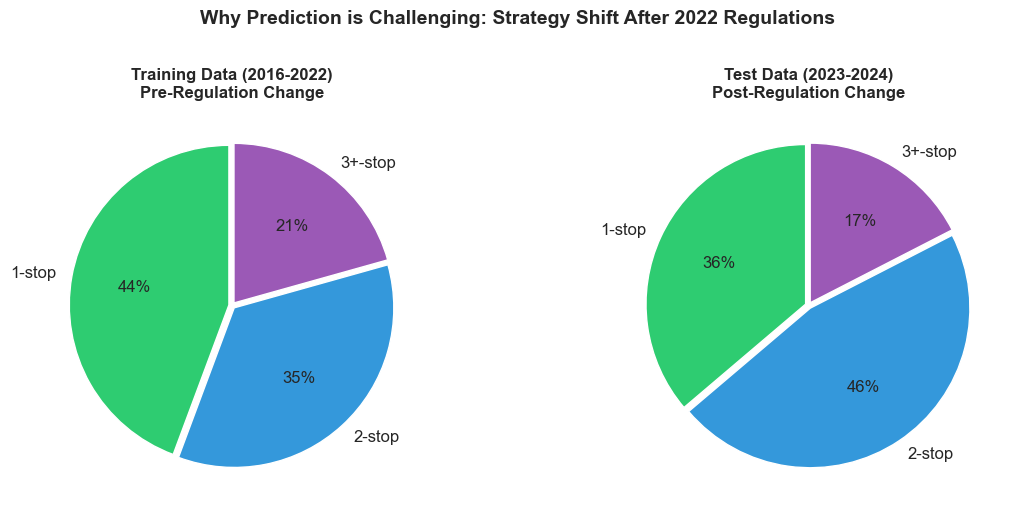

KEY TAKEAWAYS: 

- 2022 F1 regulations changed pit stop strategies.
- Training data is mostly 1-stop, but test data is mostly 2-stop!

The visualization highlights a distribution shift in pit stop strategies following the 2022 Formula 1 regulation changes.
In the training data (2016-2022), 1-stop strategies dominate (44%), while 2-stop strategies account for 35%.
In contrast, the test data (2023-2024) is primarily 2-stop races (46%), with a reduced share of 1-stop strategies (36%).

This shift indicates that the model is trained on a strategy landscape that differs structurally from the test period.
As a result, classification performance is constrained by temporal distribution mismatch, 
making post-2022 pit strategy prediction inherently more challenging even with a chronological split.


In [79]:
# The distribution shift problem (Why Chronological is Harder)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Get class distributions
train_dist = df.iloc[:int(0.70 * len(df))]['pitstop_class'].value_counts(normalize=True).sort_index()
test_dist = df.iloc[int(0.85 * len(df)):]['pitstop_class'].value_counts(normalize=True).sort_index()

classes = ['1-stop', '2-stop', '3+-stop']
colors = ['#2ecc71', '#3498db', '#9b59b6']

# Training data distribution
axes[0].pie(train_dist.values, labels=classes, autopct='%1.0f%%', colors=colors, 
            explode=(0.02, 0.02, 0.02), startangle=90, textprops={'fontsize': 12})
axes[0].set_title('Training Data (2016-2022)\nPre-Regulation Change', fontsize=12, fontweight='bold')

# Test data distribution  
axes[1].pie(test_dist.values, labels=classes, autopct='%1.0f%%', colors=colors,
            explode=(0.02, 0.02, 0.02), startangle=90, textprops={'fontsize': 12})
axes[1].set_title('Test Data (2023-2024)\nPost-Regulation Change', fontsize=12, fontweight='bold')

plt.suptitle('Why Prediction is Challenging: Strategy Shift After 2022 Regulations', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("KEY TAKEAWAYS: \n\n- 2022 F1 regulations changed pit stop strategies.\n- Training data is mostly 1-stop, but test data is mostly 2-stop!")
print("")
print("The visualization highlights a distribution shift in pit stop strategies following the 2022 Formula 1 regulation changes.")
print("In the training data (2016-2022), 1-stop strategies dominate (44%), while 2-stop strategies account for 35%.")
print("In contrast, the test data (2023-2024) is primarily 2-stop races (46%), with a reduced share of 1-stop strategies (36%).")
print("")
print("This shift indicates that the model is trained on a strategy landscape that differs structurally from the test period.")
print("As a result, classification performance is constrained by temporal distribution mismatch, \nmaking post-2022 pit strategy prediction inherently more challenging even with a chronological split.")




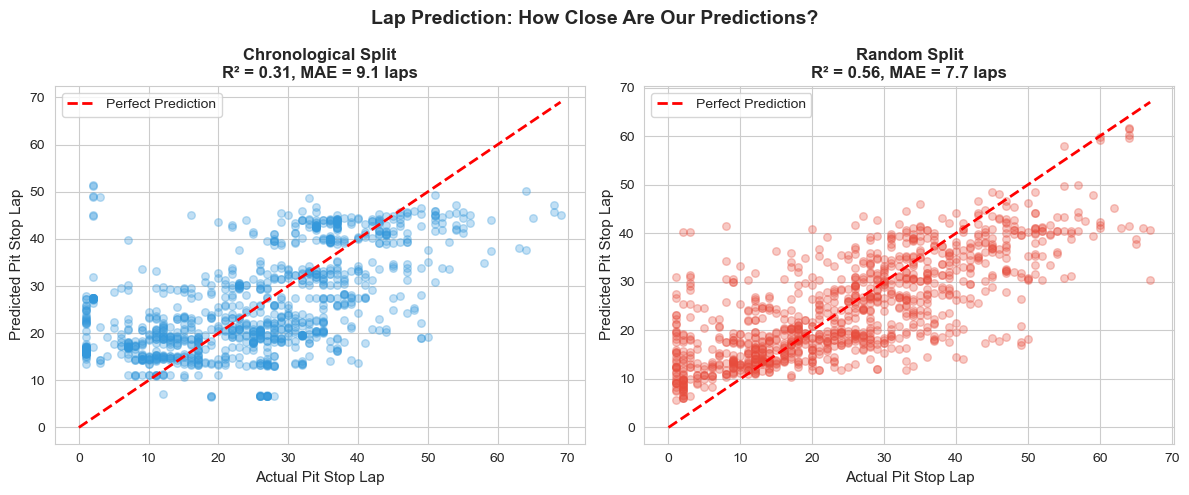

KEY TAKEAWAY: 
- Points closer to red line = better predictions.
- On average, we're off by 9.1 laps (chronological) or 7.7 laps (random).
- Random splits overestimate pit stop prediction accuracy, while chronological evaluation reveals the realistic limits of predictive performance under strategy evolution.


In [80]:
# Lap Prediction
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Chronological
y_pred_lap_chrono = lap_regressor.predict(X_test_lap_scaled)
axes[0].scatter(y_test_lap, y_pred_lap_chrono, alpha=0.3, s=30, c='#3498db')
max_val = max(y_test_lap.max(), y_pred_lap_chrono.max())
axes[0].plot([0, max_val], [0, max_val], 'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Pit Stop Lap', fontsize=11)
axes[0].set_ylabel('Predicted Pit Stop Lap', fontsize=11)
axes[0].set_title(f'Chronological Split\nR² = {test_r2_lap:.2f}, MAE = {test_mae_lap:.1f} laps', 
                  fontsize=12, fontweight='bold')
axes[0].legend()

# Random
y_pred_lap_rand = lap_reg_rand.predict(X_test_lap_r_scaled)
axes[1].scatter(y_test_lap_r, y_pred_lap_rand, alpha=0.3, s=30, c='#e74c3c')
max_val = max(y_test_lap_r.max(), y_pred_lap_rand.max())
axes[1].plot([0, max_val], [0, max_val], 'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Pit Stop Lap', fontsize=11)
axes[1].set_ylabel('Predicted Pit Stop Lap', fontsize=11)
axes[1].set_title(f'Random Split\nR² = {test_r2_lap_rand:.2f}, MAE = {test_mae_lap_rand:.1f} laps', 
                  fontsize=12, fontweight='bold')
axes[1].legend()

plt.suptitle('Lap Prediction: How Close Are Our Predictions?', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("KEY TAKEAWAY: \n- Points closer to red line = better predictions.")
print(f"- On average, we're off by {test_mae_lap:.1f} laps (chronological) or {test_mae_lap_rand:.1f} laps (random).")
print("- Random splits overestimate pit stop prediction accuracy, while chronological evaluation reveals the realistic limits of predictive performance under strategy evolution.")

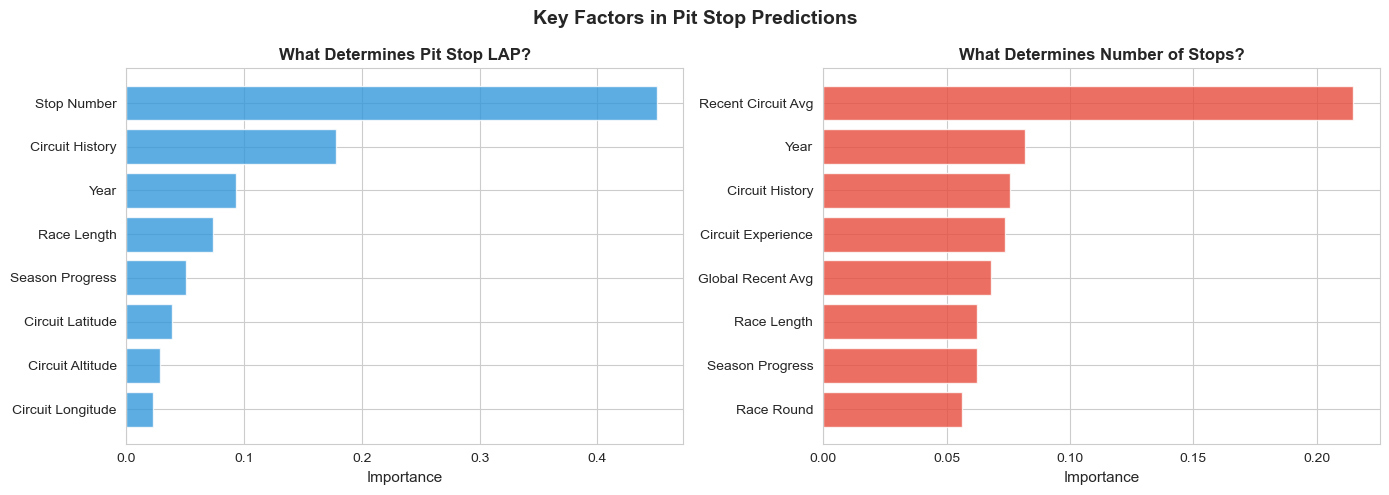

KEY TAKEAWAY: 
- Historical patterns at each circuit and for each team are the strongest predictors.


In [81]:
# Top factors influencing predictions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Lap Regression - Top 8 features
lap_importance = pd.DataFrame({'Feature': lap_features, 'Importance': lap_regressor.feature_importances_})
lap_importance = lap_importance.nlargest(8, 'Importance').sort_values('Importance')

# Clean feature names for display
feature_names_clean = {
    'circuit_hist_avg_lap': 'Circuit History',
    'constructor_hist_avg_lap': 'Team History', 
    'driver_hist_avg_lap': 'Driver History',
    'total_race_laps': 'Race Length',
    'stop': 'Stop Number',
    'grid_cleaned': 'Grid Position',
    'quali_position': 'Qualifying Position',
    'season_progress': 'Season Progress',
    'year': 'Year',
    'round': 'Race Round',
    'lat': 'Circuit Latitude',
    'lng': 'Circuit Longitude',
    'alt': 'Circuit Altitude',
    'is_new_regs': '2022+ Regulations'
}
lap_importance['Feature_Clean'] = lap_importance['Feature'].map(lambda x: feature_names_clean.get(x, x))

axes[0].barh(lap_importance['Feature_Clean'], lap_importance['Importance'], color='#3498db', alpha=0.8)
axes[0].set_xlabel('Importance', fontsize=11)
axes[0].set_title('What Determines Pit Stop LAP?', fontsize=12, fontweight='bold')

# Classification - Top 8 features
clf_importance = pd.DataFrame({'Feature': clf_features_available, 'Importance': xgb_clf_chrono.feature_importances_})
clf_importance = clf_importance.nlargest(8, 'Importance').sort_values('Importance')

feature_names_clean_clf = {
    'circuit_recent_avg': 'Recent Circuit Avg',
    'constructor_recent_avg': 'Recent Team Avg',
    'driver_recent_avg': 'Recent Driver Avg',
    'global_recent_avg': 'Global Recent Avg',
    'circuit_hist_avg': 'Circuit History',
    'constructor_hist_avg': 'Team History',
    'driver_hist_avg': 'Driver History',
    'total_race_laps': 'Race Length',
    'grid_position': 'Grid Position',
    'quali_position': 'Qualifying Position',
    'race_in_season_pct': 'Season Progress',
    'is_2022_plus': '2022+ Regulations',
    'circuit_race_count': 'Circuit Experience',
    'year': 'Year',
    'race_round': 'Race Round'
}
clf_importance['Feature_Clean'] = clf_importance['Feature'].map(lambda x: feature_names_clean_clf.get(x, x))

axes[1].barh(clf_importance['Feature_Clean'], clf_importance['Importance'], color='#e74c3c', alpha=0.8)
axes[1].set_xlabel('Importance', fontsize=11)
axes[1].set_title('What Determines Number of Stops?', fontsize=12, fontweight='bold')

plt.suptitle('Key Factors in Pit Stop Predictions', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("KEY TAKEAWAY: \n- Historical patterns at each circuit and for each team are the strongest predictors.")

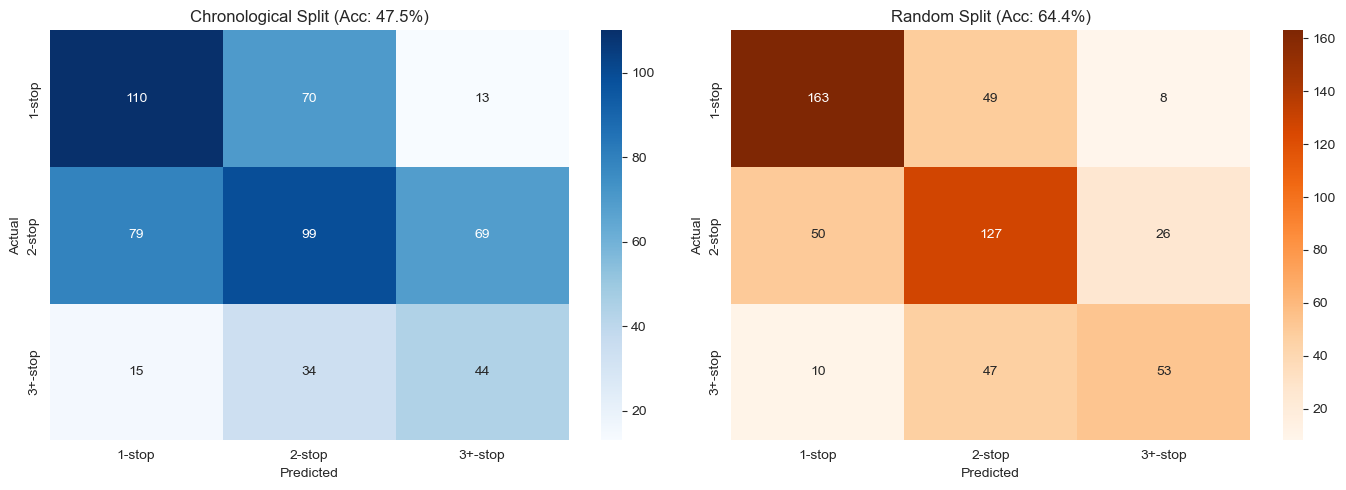

In [82]:
# Confusion Matrix Comparison of Chronological vs Random Split
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm_chrono = confusion_matrix(y_test_clf, y_pred_clf)
sns.heatmap(cm_chrono, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['1-stop', '2-stop', '3+-stop'], yticklabels=['1-stop', '2-stop', '3+-stop'])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title(f'Chronological Split (Acc: {test_acc_clf*100:.1f}%)')

cm_rand = confusion_matrix(y_test_clf_r, y_pred_rand)
sns.heatmap(cm_rand, annot=True, fmt='d', cmap='Oranges', ax=axes[1],
            xticklabels=['1-stop', '2-stop', '3+-stop'], yticklabels=['1-stop', '2-stop', '3+-stop'])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title(f'Random Split (Acc: {test_acc_rand*100:.1f}%)')

plt.tight_layout()
plt.show()

---
# SUMMARY
---

## Models Created & Performance Achieved:

| Model | Task | Algorithm | Split | Train Score | Test Score |
|-------|------|-----------|-------|-------------|------------|
| A1 | Lap Number Regression | RandomForestRegressor | Chronological 70/15/15 | R2: 0.667 | R2: 0.313 |
| A2 | Pit Stop Classification | **XGBClassifier** | Chronological 85/15 | Acc: 78.1 | Acc: 47.5 |
| B1 | Lap Number Regression | RandomForestRegressor | Random 70/15/15 | R2: 0.644 | R2: 0.565 |
| B2 | Pit Stop Classification | **XGBClassifier** | Random 70/15/15 | Acc: 79.0 | Acc: 64.4 |

## Key Improvements:
1. **XGBoost** for classification: handles distribution shift better and helps us utilise the limited data via regularization.
2. **Train+Validation data combined** (85% data) for chronological classification improves overall performance
3. **Recent rolling averages** as features (captures regulation changes)

## XGBoost Hyperparameters:
- `n_estimators=200`: Number of boosting rounds
- `max_depth=4`: Shallow trees for generalization
- `learning_rate=0.05`: Small steps to avoid overfitting
- `subsample=0.8`: Row sampling for regularization
- `colsample_bytree=0.8`: Column sampling for regularization
- `reg_alpha=0.1, reg_lambda=1.0`: L1 and L2 regularization